<a href="https://colab.research.google.com/github/abajr516/Google4/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Problem** : predict the revenue generated by the customer (in dollars) when s/he visits the store

**Ref Source** : https://www.kaggle.com/competitions/ga-customer-revenue-prediction/overview

Loading data from Kaggle : I downloaded my API token from Kaggle (kaggle.json) and ran the following commands to be able to download the data directly from Kaggle on Google Colab

Ref : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c ga-customer-revenue-prediction

 99% 1.55G/1.56G [00:19<00:00, 70.1MB/s]
100% 1.56G/1.56G [00:19<00:00, 85.1MB/s]


In [ ]:
! unzip ga-customer-revenue-prediction.zip

Archive:  ga-customer-revenue-prediction.zip
  inflating: sample_submission.csv   
  inflating: sample_submission_v2.csv  
  inflating: test.csv                
  inflating: test_v2.csv             
  inflating: train.csv               
  inflating: train_v2.csv            


Importing libraries we might need

In [ ]:
# importing libraries

import os
import json
import gc
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif

Quick data check

In [ ]:
df = pd.read_csv('/content/train_v2.csv', nrows=10)
df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


We can see that four features in the train & test datasets are in the JSON form - 'device', 'geoNetwork', 'totals', 'trafficSource. These features need to be flattened out. We have a refernce function written which I am going to be using for this : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook

In [ ]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows,
                     on_bad_lines='skip')

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

Creating Train and Test Dataframes

Creating a smaller dataframe for the ease of use

We would be using Pandas Dataframe : for more information please read https://towardsdatascience.com/why-and-how-to-use-pandas-with-large-data-9594dda2ea4c

In [ ]:
small_train_df = load_df('/content/train_v2.csv', nrows = 100000)

<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])


Loaded train_v2.csv. Shape: (100000, 59)


Quick data check - makes use realize that there columns we can drop and

In [ ]:
small_train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,NaN,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Getting a list of all the column names

In [ ]:
small_train_df.columns.to_list()

['channelGrouping',
 'customDimensions',
 'date',
 'fullVisitorId',
 'hits',
 'socialEngagementType',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystem',
 'device.operatingSystemVersion',
 'device.isMobile',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.cityId',
 'geoNetwork.networkDomain',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.sessionQualityDim',
 'totals.timeOnSite',
 'total

Check for each column how many unique values are present. If count is one, that means same value exists for that feature across the data-set. Hence that  feature will not help us for any kind of predictions. So we are drop those columns.

In [ ]:
small_train_df.nunique()

channelGrouping                                          8
customDimensions                                         6
date                                                    38
fullVisitorId                                        90097
hits                                                 93602
socialEngagementType                                     1
visitId                                              98072
visitNumber                                            210
visitStartTime                                       98062
device.browser                                          35
device.browserVersion                                    1
device.browserSize                                       1
device.operatingSystem                                  18
device.operatingSystemVersion                            1
device.isMobile                                          2
device.mobileDeviceBranding                              1
device.mobileDeviceModel                                

Create a list of columns we would want to drop

In [ ]:
column_names = small_train_df.columns.to_list()
unique_value_columns=[]
for column in column_names:
    count = small_train_df[column].nunique()
    if count==1:
        unique_value_columns.append(column)
print(unique_value_columns)

['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']


Analysis of missing values. Here we are checking in each colummn how much percentage of data missed

Credits : https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset

In [ ]:
percent_missing = small_train_df.isnull().sum() * 100 / len(small_train_df)  #{ (total nulls in particular column*100)/total no.of rows }
missing_value = pd.DataFrame({'column_name': small_train_df.columns, 'percent_missing': percent_missing})

In [ ]:
missing_value

,column_name,percent_missing
channelGrouping,channelGrouping,0.000
customDimensions,customDimensions,0.000
date,date,0.000
fullVisitorId,fullVisitorId,0.000
hits,hits,0.000
socialEngagementType,socialEngagementType,0.000
visitId,visitId,0.000
visitNumber,visitNumber,0.000
visitStartTime,visitStartTime,0.000
device.browser,device.browser,0.000


In [ ]:
def clean_df(df):
  # drop features where same value exists through the dataset
  column_names = df.columns.to_list()
  for column in column_names:
      count = df[column].nunique()
      if count==1:
          df = df.drop(columns=column)

  # drop transactionRevenue, use "totals.totalTransactionRevenue" instead
  df = df.drop(columns='totals.transactionRevenue')

  # fill in empty rows
  df["totals.totalTransactionRevenue"] = df["totals.totalTransactionRevenue"].fillna("0").astype(float)
  df["totals.pageviews"] = df["totals.pageviews"].fillna(0).astype(int)
  df["totals.sessionQualityDim"] = df["totals.sessionQualityDim"].fillna("1").astype(int)

  # drop columns with a higher percentage of missing values that can't be filled in
  # as these features would not be of much use to us
  df = df.drop(columns='trafficSource.adwordsClickInfo.page')
  df = df.drop(columns='trafficSource.adwordsClickInfo.slot')
  df = df.drop(columns='trafficSource.adwordsClickInfo.gclId')
  df = df.drop(columns='trafficSource.adwordsClickInfo.adNetworkType')
  df = df.drop(columns='trafficSource.keyword')
  df = df.drop(columns='trafficSource.referralPath')
  df = df.drop(columns='trafficSource.adContent')
  return df

In [ ]:
small_train_df = clean_df(small_train_df)

In [ ]:
# rename the columns that were extracted from the jsons to make them cleaner
small_train_df = small_train_df.rename(columns={
      "device.browser": "browser",
      "device.operatingSystem": "operatingSystem",
      "device.isMobile": "isMobile",
      "device.deviceCategory": "deviceCategory",
      "geoNetwork.continent": "continent",
      "geoNetwork.subContinent": "subContinent",
      "geoNetwork.country": "country",
      "geoNetwork.region": "region",
      "geoNetwork.metro": "metro",
      "geoNetwork.city": "city",
      "geoNetwork.networkDomain": "networkDomain",
      "totals.hits": "hits",
      "totals.pageviews": "pageviews",
      "totals.sessionQualityDim": "sessionQualityDim",
      "totals.timeOnSite": "timeOnSite",
      "totals.transactions": "transactions",
      "totals.totalTransactionRevenue": "totalTransactionRevenue",
      "trafficSource.campaign": "campaign",
      "trafficSource.source": "source",
      "trafficSource.medium": "medium"})

In [ ]:
small_train_df.columns.to_list()

['channelGrouping',
 'customDimensions',
 'date',
 'fullVisitorId',
 'hits',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'browser',
 'operatingSystem',
 'isMobile',
 'deviceCategory',
 'continent',
 'subContinent',
 'country',
 'region',
 'metro',
 'city',
 'networkDomain',
 'hits',
 'pageviews',
 'sessionQualityDim',
 'timeOnSite',
 'transactions',
 'totalTransactionRevenue',
 'campaign',
 'source',
 'medium']

# Exploratory Data Analysis

**Target Variable Analysis**

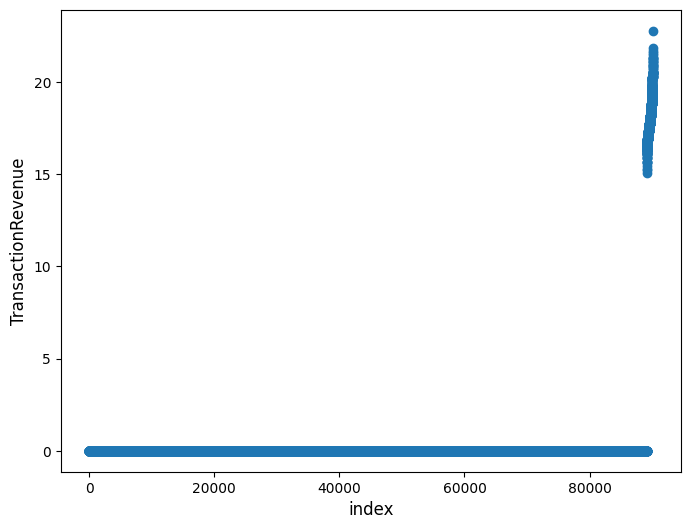

In [ ]:
small_train_df["totalTransactionRevenue"] = small_train_df["totalTransactionRevenue"].astype('float')
# for each user we are taking sum of all their transactions
sum = small_train_df.groupby("fullVisitorId")["totalTransactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(sum.shape[0]), np.sort(np.log1p(sum["totalTransactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

Here we see the 80/20 rule in action where any business's revenue comes from a tiny fraction of it's users

**Trend over time Analysis**

Plot for number of visits to the site over time

In [ ]:
# convert date feature into exact date format
small_train_df["date"] = pd.to_datetime(small_train_df["date"], infer_datetime_format=True, format="%Y%m%d")


In [ ]:
# Compute count of group, excluding missing values(include only non zero values).
group_date = small_train_df.groupby('date').count()
group_date.reset_index(inplace=True)

In [ ]:
group_date.head()

,date,channelGrouping,customDimensions,fullVisitorId,hits,visitId,visitNumber,visitStartTime,browser,operatingSystem,...,networkDomain,hits,pageviews,sessionQualityDim,timeOnSite,transactions,totalTransactionRevenue,campaign,source,medium
0,2016-08-11,2667,2667,2667,2667,2667,2667,2667,2667,2667,...,2667,2667,2667,2667,1376,47,2667,2667,2667,2667
1,2016-09-02,2613,2613,2613,2613,2613,2613,2613,2613,2613,...,2613,2613,2613,2613,1287,30,2613,2613,2613,2613
2,2016-10-14,2838,2838,2838,2838,2838,2838,2838,2838,2838,...,2838,2838,2838,2838,1377,21,2838,2838,2838,2838
3,2016-11-10,4055,4055,4055,4055,4055,4055,4055,4055,4055,...,4055,4055,4055,4055,1839,25,4055,4055,4055,4055
4,2016-11-12,3119,3119,3119,3119,3119,3119,3119,3119,3119,...,3119,3119,3119,3119,1583,15,3119,3119,3119,3119


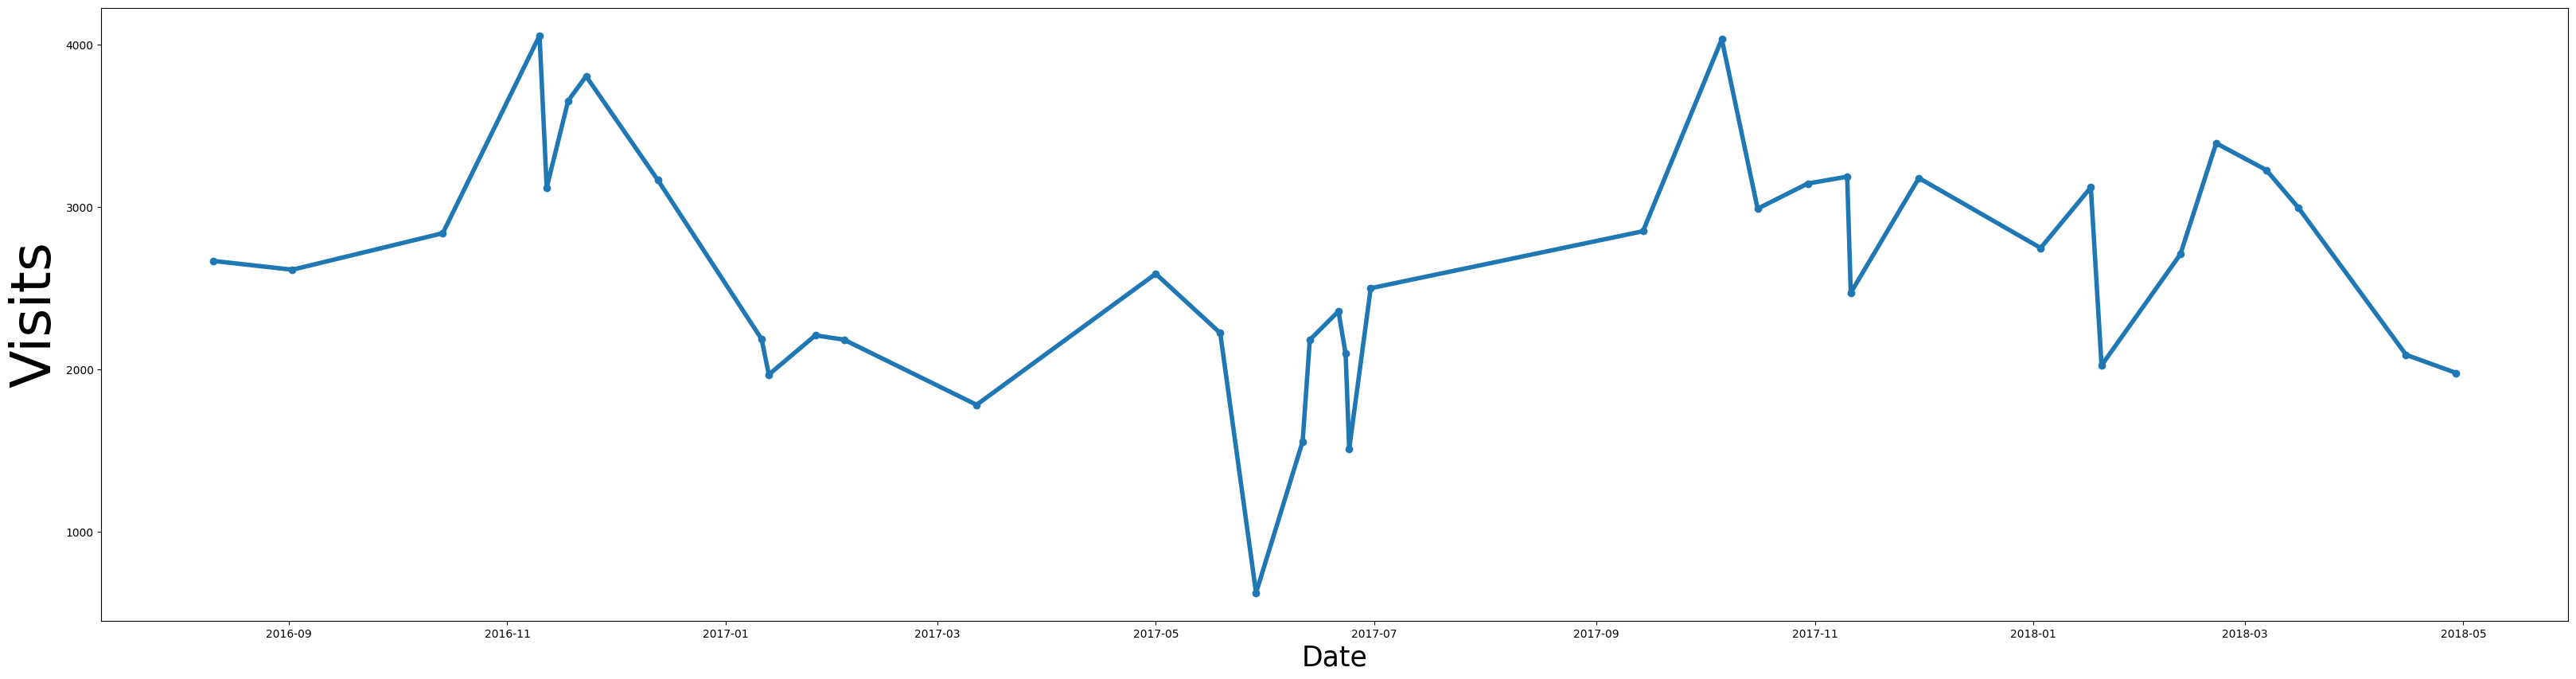

In [ ]:
plt.figure(figsize=(40,10))
plt.plot_date(x = group_date['date'], y = group_date['fullVisitorId'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Visits',fontsize=50)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.autoscale(True)
plt.show()

In [ ]:
#https://stackoverflow.com/questions/30405413/pandas-extract-year-from-datetime-dfyear-dfdate-year-is-not-working
small_train_df["month"] = small_train_df["date"].dt.month # FEATURE ENGINEERING MONTH COLUMN

In [ ]:
small_train_df['month'].dtype

dtype('int64')

In [ ]:
group_month = small_train_df.groupby('month').count()
group_month.reset_index(inplace=True)

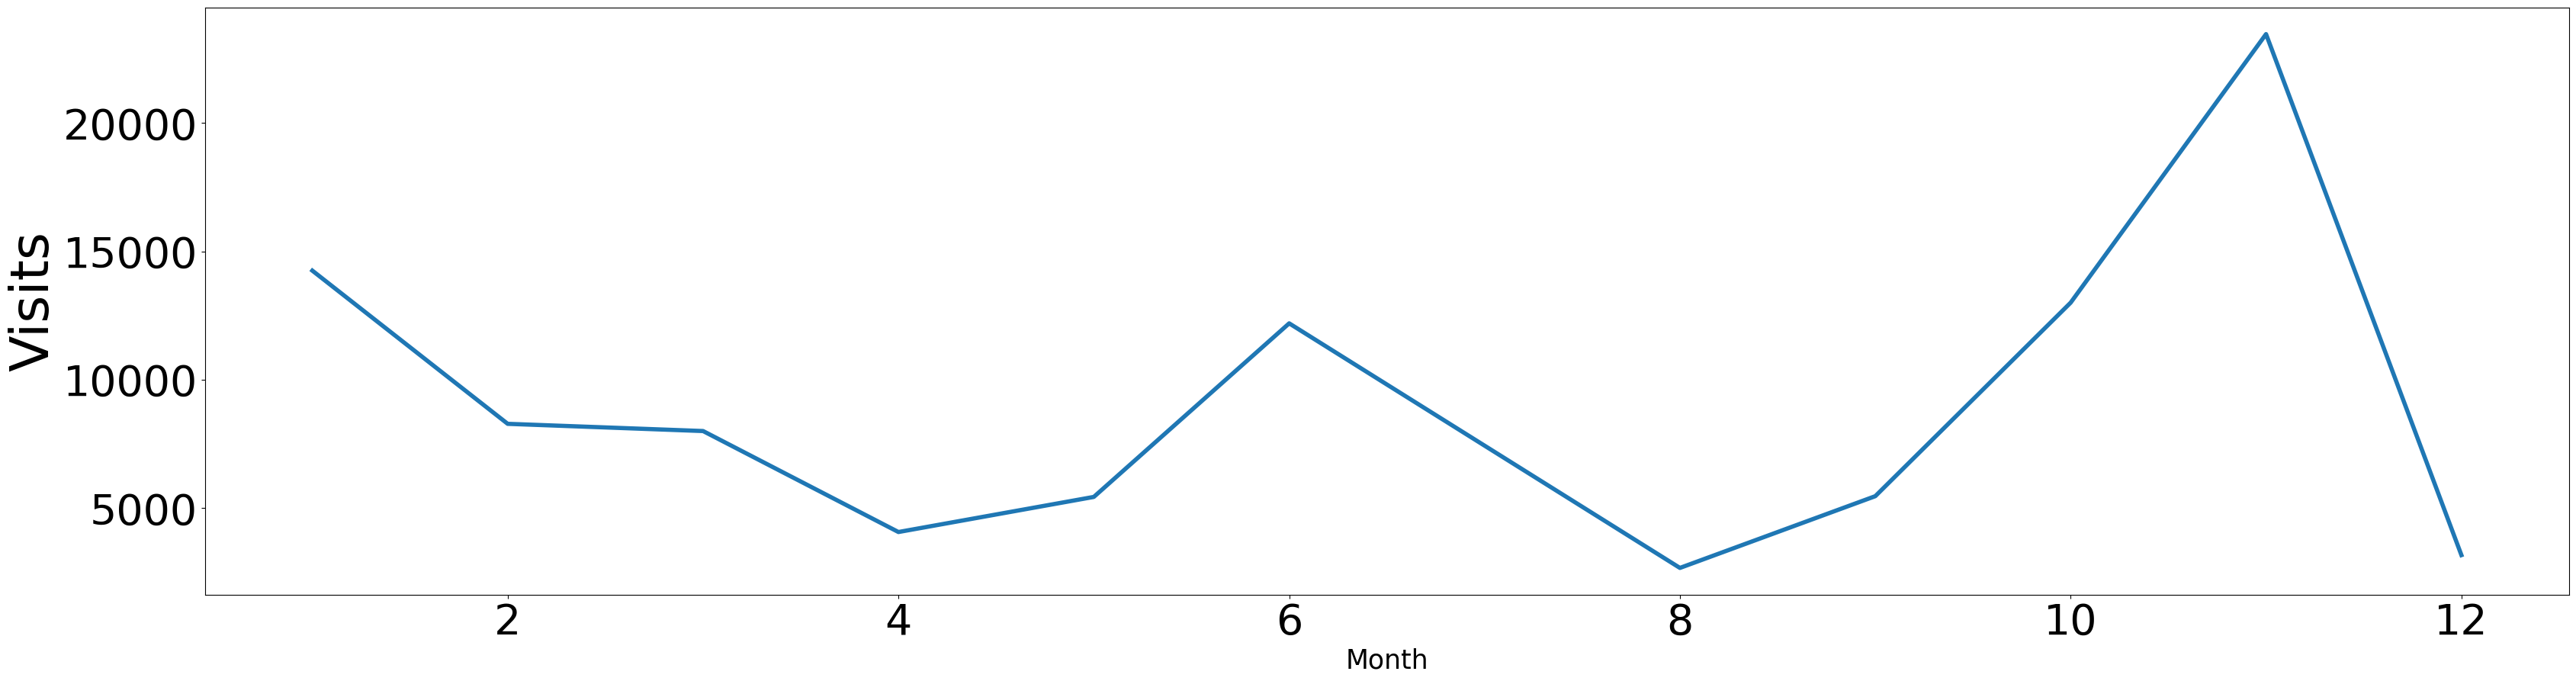

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(group_month['month'], group_month['fullVisitorId'],linestyle='solid',linewidth=4)
plt.xlabel('Month',fontsize=25)
plt.ylabel('Visits',fontsize=50)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.autoscale(True)
plt.show()

In [ ]:
small_train_df["visitStartTime"] = pd.to_datetime(small_train_df['visitStartTime'], unit='s')

In [ ]:
small_train_df["hour"] = small_train_df["visitStartTime"].dt.hour # FEATURE ENGINEERING HOUR COLUMN

In [ ]:
group_hour= small_train_df.groupby('hour').count()
group_hour.reset_index(inplace=True)

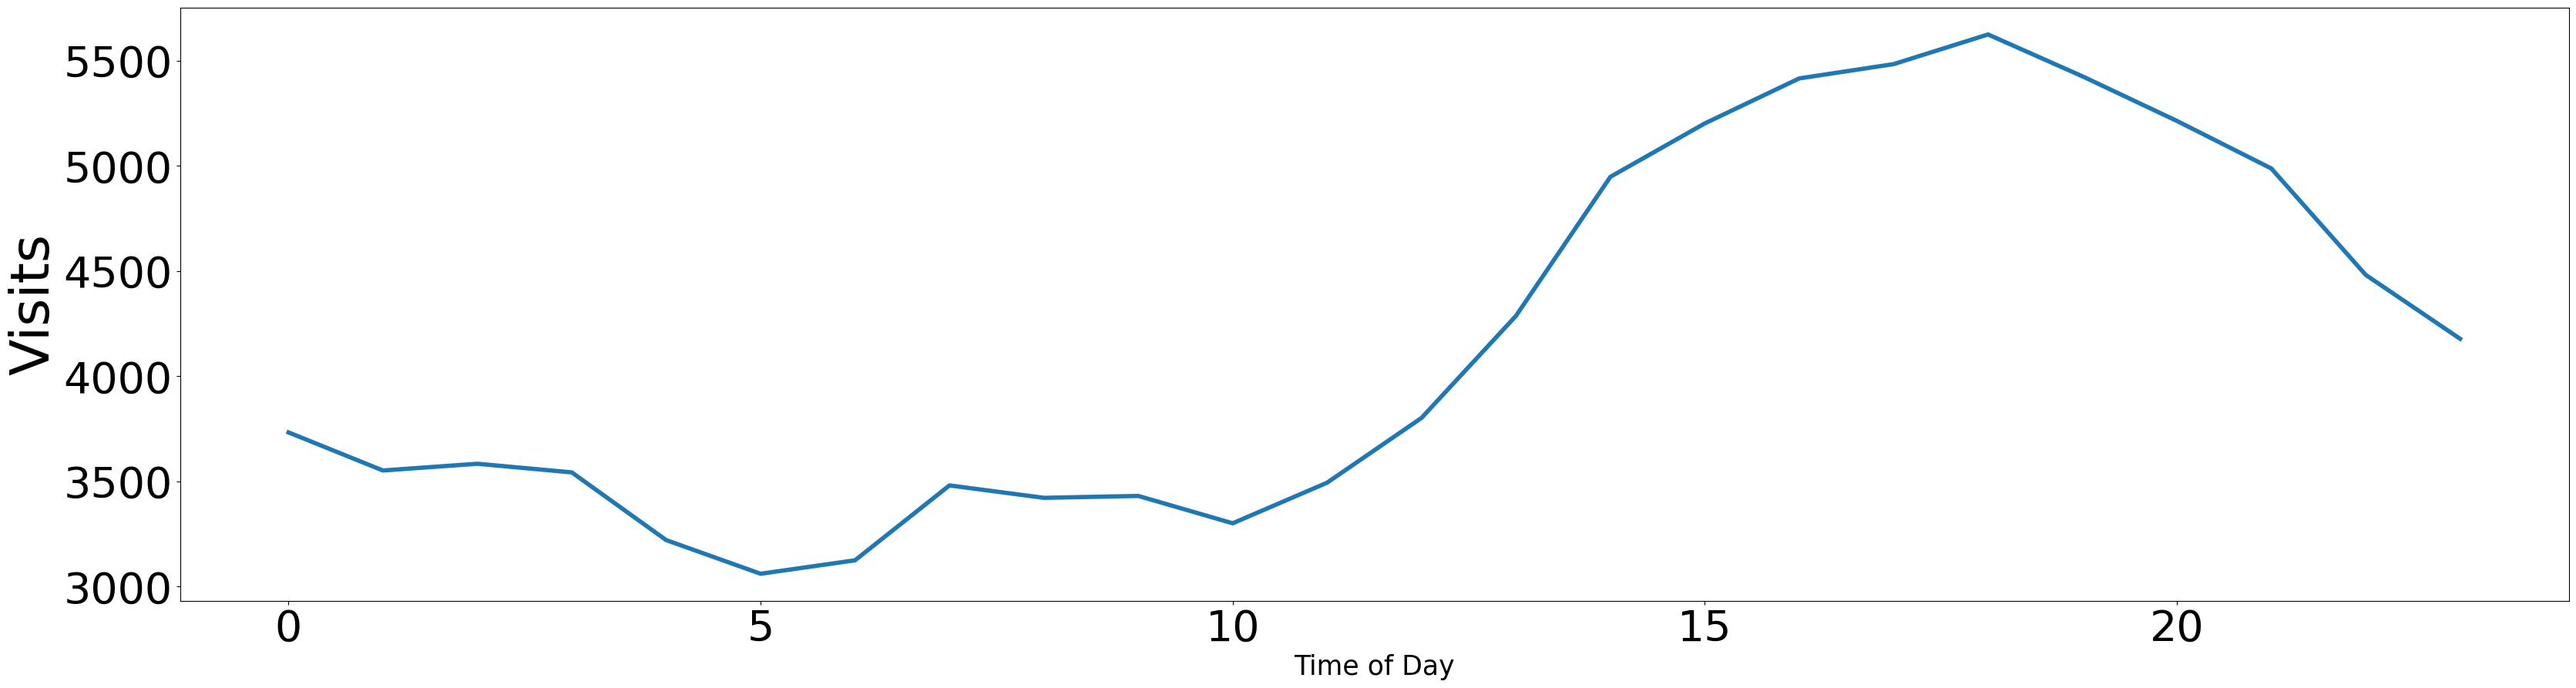

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(group_hour['hour'], group_hour['fullVisitorId'],linestyle='solid',linewidth=4)
plt.xlabel('Time of Day',fontsize=25)
plt.ylabel('Visits',fontsize=50)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.autoscale(True)
plt.show()

Text(0.5, 1.0, 'Effect of channel grouping on transaction revenue')

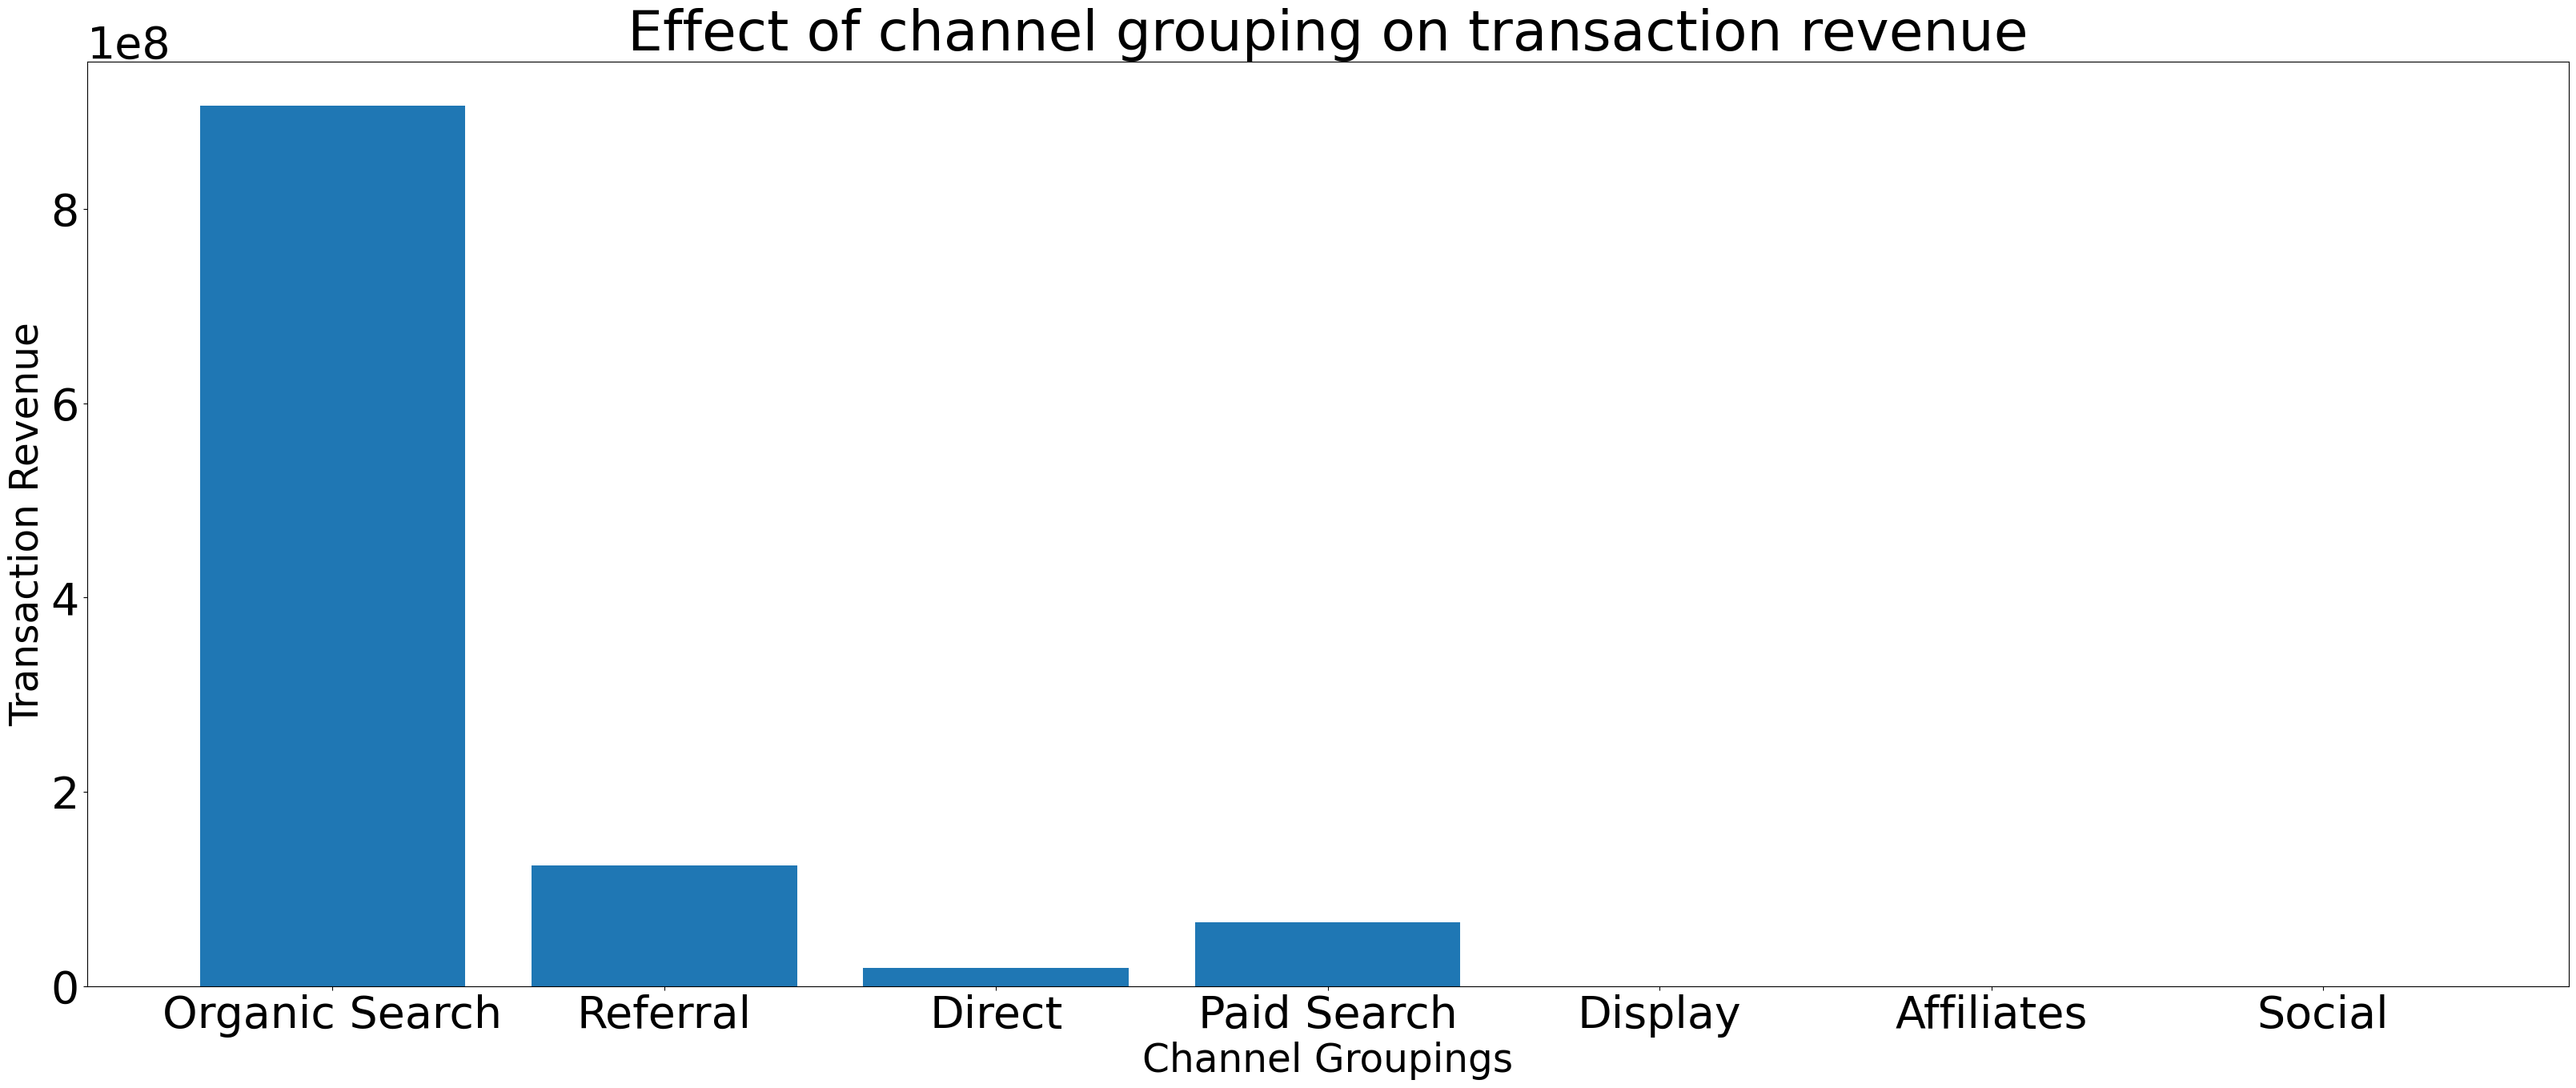

In [ ]:
X = small_train_df['channelGrouping']
Y = small_train_df['totalTransactionRevenue']

fig = plt.figure(figsize =(40,15))

plt.bar(X[0:2000], Y[0:2000])

plt.xlabel("Channel Groupings", fontsize=35)
plt.ylabel("Transaction Revenue", fontsize=35)
plt.title("Effect of channel grouping on transaction revenue", fontsize=50)

In [ ]:
int_features_list = list(small_train_df.select_dtypes(include=['int64', 'float64']))

In [ ]:
int_features = small_train_df.select_dtypes(include=['int64', 'float64'])

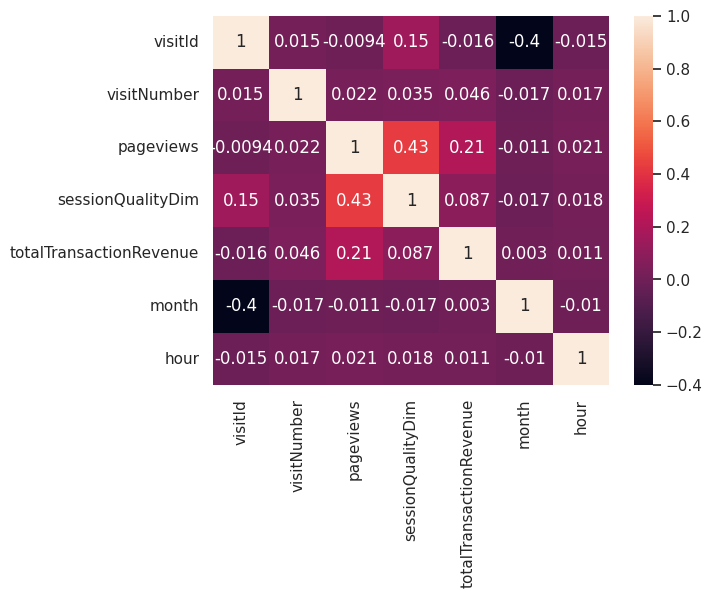

In [ ]:
corr_matrix = int_features.corr()
sns.set(font_scale=1)
sns.heatmap(corr_matrix, annot=True);

In [ ]:
group_continent = small_train_df.groupby('continent').count()
group_continent.reset_index(inplace=True)

Text(0.5, 1.0, 'Continents generating the most revenue')

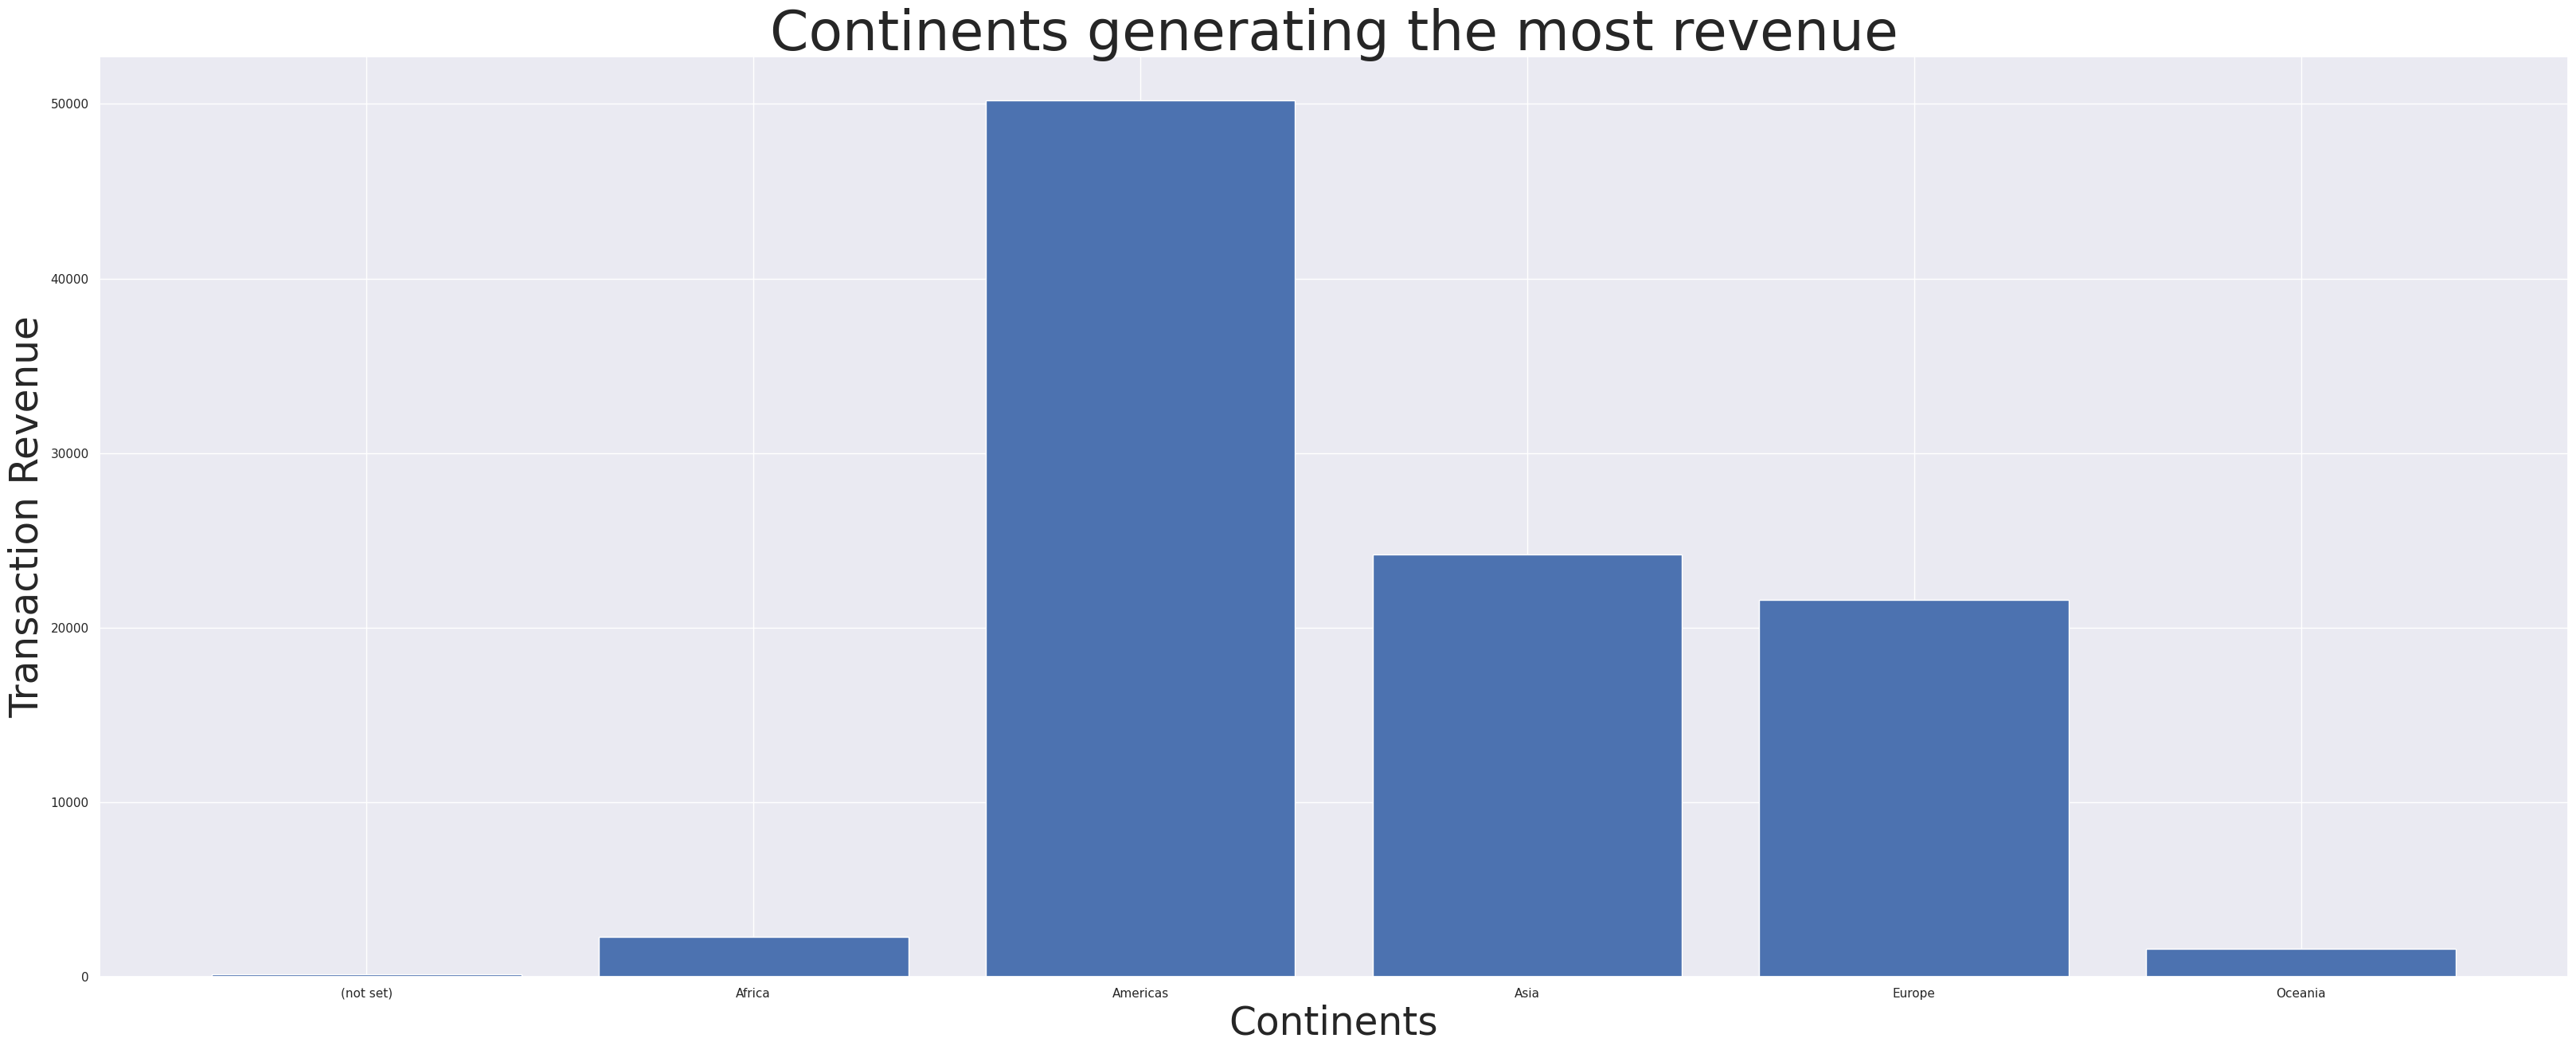

In [ ]:
X = group_continent['continent']
Y = group_continent['totalTransactionRevenue']

fig = plt.figure(figsize =(40,15))

plt.bar(X, Y)

plt.xlabel("Continents", fontsize=35)
plt.ylabel("Transaction Revenue", fontsize=35)
plt.title("Continents generating the most revenue", fontsize=50)

In [ ]:
group_region = small_train_df.groupby('region').count()
group_region.reset_index(inplace=True)
group_region = group_region.sort_values(by=['totalTransactionRevenue'], ascending=False)
group_region.reset_index(inplace=True)

In [ ]:
group_region=group_region.drop(group_region.index[[0,2]]) #removed irrelevant columns such as data not set and demo data

In [ ]:
group_region.head(10)

,index,region,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,...,pageviews,sessionQualityDim,timeOnSite,transactions,totalTransactionRevenue,campaign,source,medium,month,hour
1,37,California,12296,12296,12296,12296,12296,12296,12296,12296,...,12296,12296,8741,308,12296,12296,12296,12296,12296,12296
3,141,New York,2759,2759,2759,2759,2759,2759,2759,2759,...,2759,2759,1848,140,2759,2759,2759,2759,2759,2759
4,67,England,1521,1521,1521,1521,1521,1521,1521,1521,...,1521,1521,567,0,1521,1521,1521,1521,1521,1521
5,202,Texas,1108,1108,1108,1108,1108,1108,1108,1108,...,1108,1108,645,25,1108,1108,1108,1108,1108,1108
6,94,Illinois,886,886,886,886,886,886,886,886,...,886,886,514,32,886,886,886,886,886,886
7,220,Washington,873,873,873,873,873,873,873,873,...,873,873,587,36,873,873,873,873,873,873
8,120,Maharashtra,809,809,809,809,809,809,809,809,...,809,809,348,0,809,809,809,809,809,809
9,20,Bangkok,758,758,758,758,758,758,758,758,...,758,758,346,0,758,758,758,758,758,758
10,57,Delhi,696,696,696,696,696,696,696,696,...,696,696,281,0,696,696,696,696,696,696
11,152,Ontario,648,648,648,648,648,648,648,648,...,648,648,404,7,648,648,648,648,648,648


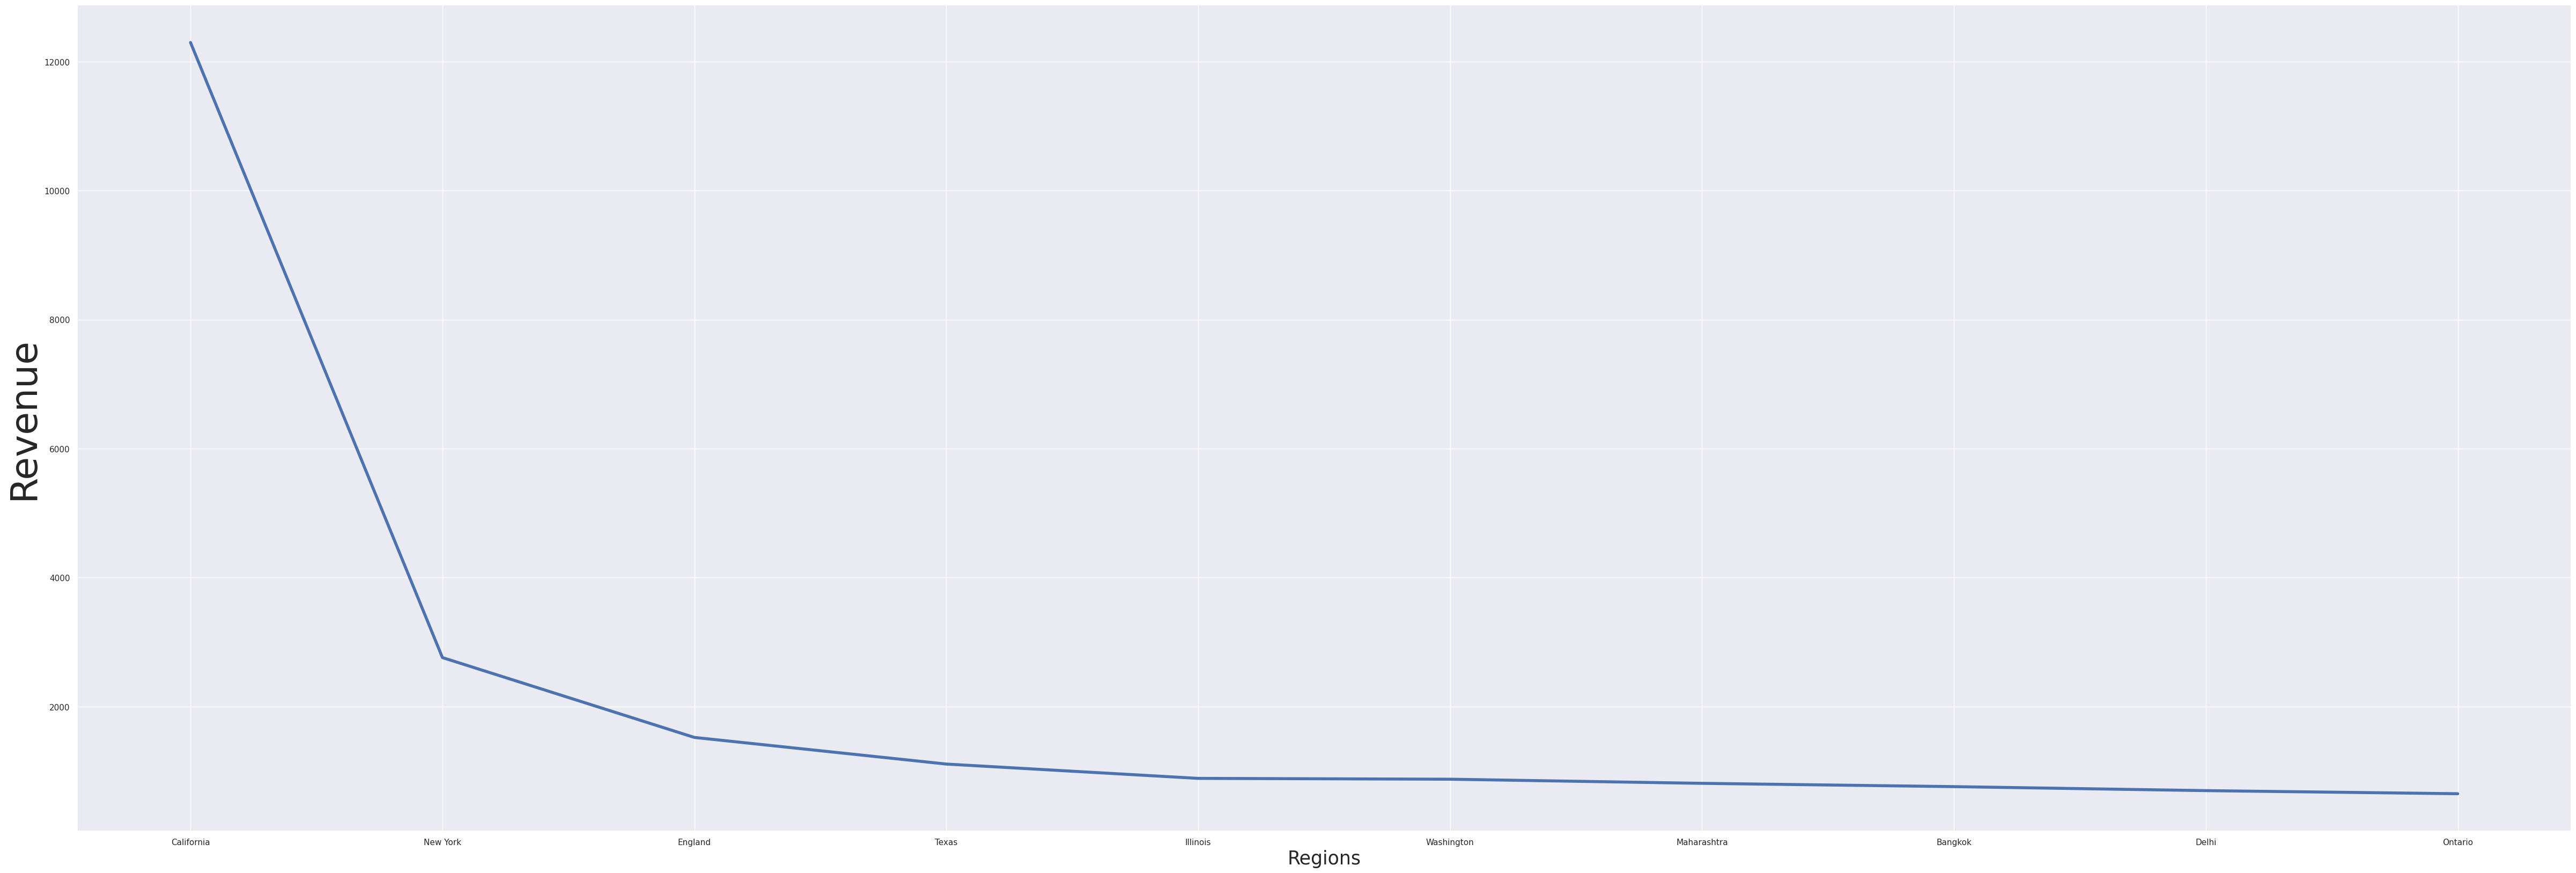

In [ ]:
plt.figure(figsize=(60,20))
plt.plot(group_region['region'].head(10), group_region['totalTransactionRevenue'].head(10),linestyle='solid',linewidth=4)
plt.xlabel('Regions',fontsize=25)
plt.ylabel('Revenue',fontsize=50)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.autoscale(True)
plt.show()

In [ ]:
group_city = small_train_df.groupby('city').count()
group_city.reset_index(inplace=True)
group_city = group_city.sort_values(by=['totalTransactionRevenue'], ascending=False)
group_city.reset_index(inplace=True)

In [ ]:
group_city.head(20)

,index,city,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,...,pageviews,sessionQualityDim,timeOnSite,transactions,totalTransactionRevenue,campaign,source,medium,month,hour
0,317,not available in demo dataset,54332,54332,54332,54332,54332,54332,54332,54332,...,54332,54332,25436,381,54332,54332,54332,54332,54332,54332
1,190,Mountain View,4460,4460,4460,4460,4460,4460,4460,4460,...,4460,4460,3354,127,4460,4460,4460,4460,4460,4460
2,0,(not set),3863,3863,3863,3863,3863,3863,3863,3863,...,3863,3863,1509,4,3863,3863,3863,3863,3863,3863
3,202,New York,2753,2753,2753,2753,2753,2753,2753,2753,...,2753,2753,1846,140,2753,2753,2753,2753,2753,2753
4,258,San Francisco,2270,2270,2270,2270,2270,2270,2270,2270,...,2270,2270,1494,64,2270,2270,2270,2270,2270,2270
5,280,Sunnyvale,1603,1603,1603,1603,1603,1603,1603,1603,...,1603,1603,1218,38,1603,1603,1603,1603,1603,1603
6,161,London,1343,1343,1343,1343,1343,1343,1343,1343,...,1343,1343,524,0,1343,1343,1343,1343,1343,1343
7,259,San Jose,1189,1189,1189,1189,1189,1189,1189,1189,...,1189,1189,787,12,1189,1189,1189,1189,1189,1189
8,162,Los Angeles,942,942,942,942,942,942,942,942,...,942,942,605,23,942,942,942,942,942,942
9,72,Chicago,840,840,840,840,840,840,840,840,...,840,840,495,32,840,840,840,840,840,840


In [ ]:
group_city=group_city.drop(group_city.index[[0,2]]) #removed irrelevant columns such as data not set and demo data

Text(0.5, 1.0, 'Cities generating the most revenue')

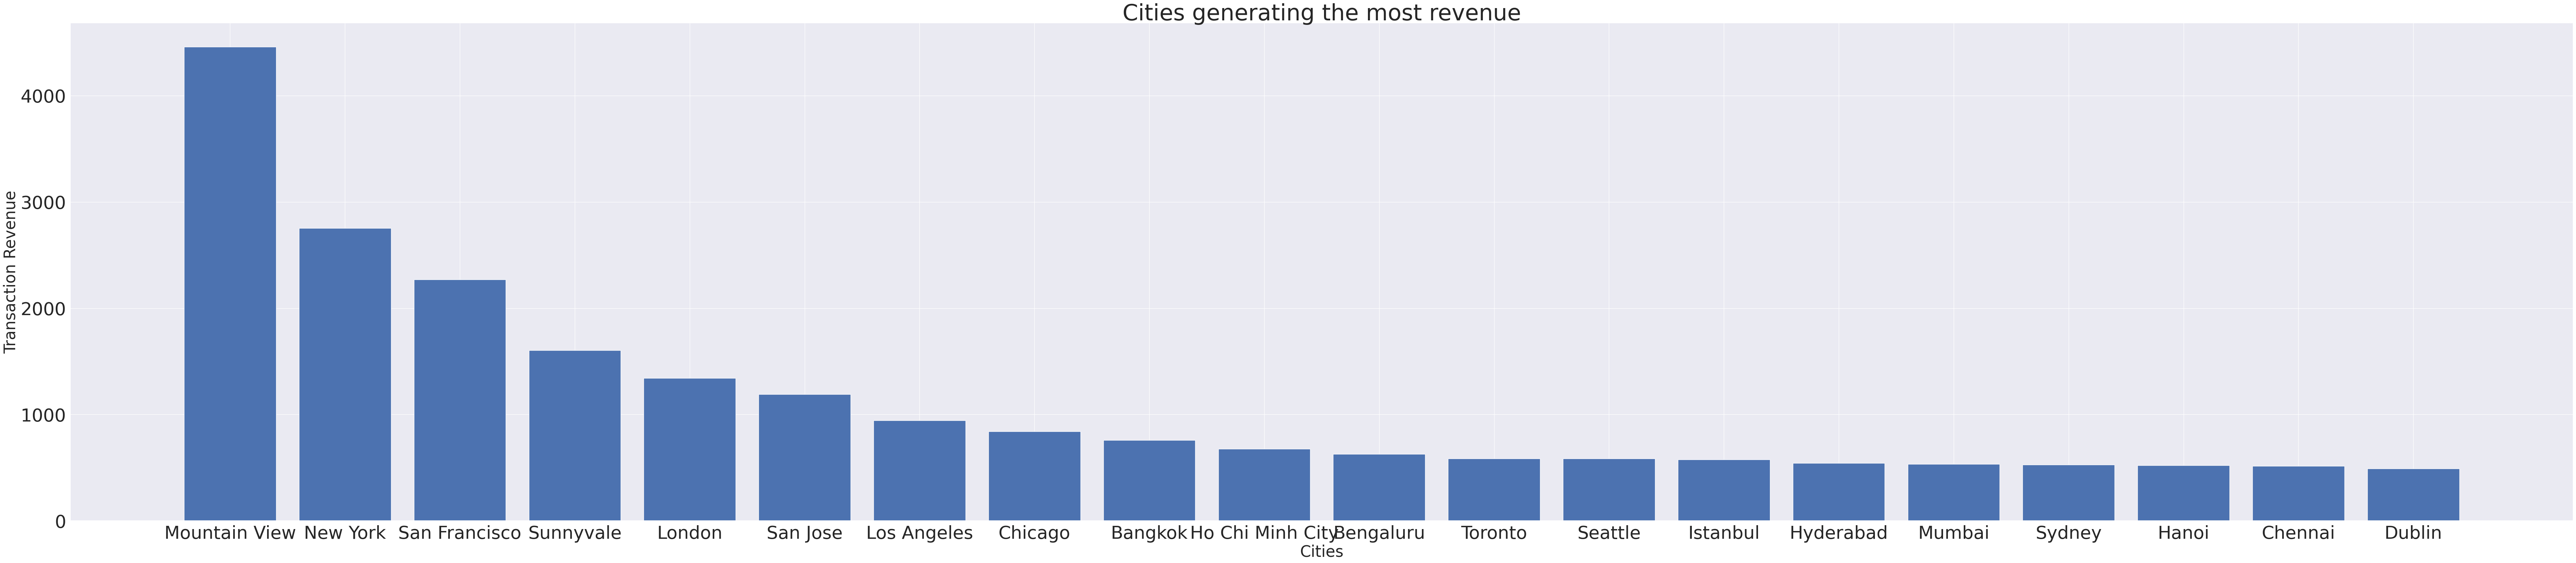

In [ ]:
X = group_city['city'].head(20)
Y = group_city['totalTransactionRevenue'].head(20)

fig = plt.figure(figsize =(100,20))

plt.bar(X, Y)

plt.xlabel("Cities", fontsize=35)
plt.ylabel("Transaction Revenue", fontsize=35)
plt.title("Cities generating the most revenue", fontsize=50)

In [ ]:
small_train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'visitId', 'visitNumber', 'visitStartTime', 'browser',
       'operatingSystem', 'isMobile', 'deviceCategory', 'continent',
       'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain',
       'hits', 'pageviews', 'sessionQualityDim', 'timeOnSite', 'transactions',
       'totalTransactionRevenue', 'campaign', 'source', 'medium', 'month',
       'hour'],
      dtype='object')

# Feature Engineering

In [ ]:
# Drop columns that add no new value
small_train_df=small_train_df.drop('subContinent', axis=1)
small_train_df=small_train_df.drop('country', axis=1)
small_train_df=small_train_df.drop('region', axis=1)
small_train_df=small_train_df.drop('metro', axis=1)
small_train_df=small_train_df.drop('city', axis=1)
small_train_df=small_train_df.drop('networkDomain', axis=1)
small_train_df=small_train_df.drop('transactions', axis=1)
small_train_df=small_train_df.drop('campaign', axis=1)

In [ ]:
#https://stackoverflow.com/questions/30405413/pandas-extract-year-from-datetime-dfyear-dfdate-year-is-not-working
small_train_df["year"] = small_train_df["date"].dt.year # FEATURE ENGINEERING MONTH COLUMN

In [ ]:
small_train_df = small_train_df.drop(columns='date', axis=1)

In [ ]:
small_train_df = small_train_df.drop(columns='visitStartTime', axis=1)

In [ ]:
int_features_list = list(small_train_df.select_dtypes(include=['int64', 'float64']))

In [ ]:
int_features_list

['visitId',
 'visitNumber',
 'pageviews',
 'sessionQualityDim',
 'totalTransactionRevenue',
 'month',
 'hour',
 'year']

In [ ]:
small_train_df['fullVisitorId'] = small_train_df['fullVisitorId'].astype('string')

In [ ]:
# mass producing max, min, avg columns for all the numerical columns whilst grouping by fullvisitorid
# goal: getting the minimum, maximum, and avg for each user
# DO NOT RERUN
for i in int_features_list:
  small_train_df[i+'_max'] = small_train_df.groupby('fullVisitorId')[i].transform('max')
  small_train_df[i+'_min'] = small_train_df.groupby('fullVisitorId')[i].transform('min')
  small_train_df[i+'_avg'] = small_train_df.groupby('fullVisitorId')[i].transform('mean')



In [ ]:
small_train_df

,channelGrouping,customDimensions,fullVisitorId,hits,visitId,visitNumber,browser,operatingSystem,isMobile,deviceCategory,...,totalTransactionRevenue_avg,month_max,month_min,month_avg,hour_max,hour_min,hour_avg,year_max,year_min,year_avg
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,Firefox,Windows,False,desktop,...,0.000000e+00,10,10,10.000000,0,0,0.000000,2017,2017,2017.000000
1,Referral,"[{'index': '4', 'value': 'North America'}]",8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,Chrome,Chrome OS,False,desktop,...,0.000000e+00,11,10,10.333333,20,13,16.666667,2017,2017,2017.000000
2,Direct,"[{'index': '4', 'value': 'North America'}]",7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,Chrome,Android,True,mobile,...,0.000000e+00,10,10,10.000000,0,0,0.000000,2017,2017,2017.000000
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,Chrome,Windows,False,desktop,...,0.000000e+00,10,10,10.000000,16,16,16.000000,2017,2017,2017.000000
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,Chrome,Windows,False,desktop,...,0.000000e+00,10,10,10.000000,21,21,21.000000,2017,2017,2017.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Direct,"[{'index': '4', 'value': 'Central America'}]",9959129121135955735,"[{'hitNumber': '1', 'time': '0', 'hour': '22',...",1496122172,1,Chrome,Windows,False,desktop,...,0.000000e+00,5,5,5.000000,5,5,5.000000,2017,2017,2017.000000
99996,Referral,"[{'index': '4', 'value': 'North America'}]",4458329221243726234,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1496087028,22,Chrome,Chrome OS,False,desktop,...,1.679333e+07,11,5,7.000000,22,5,15.333333,2017,2016,2016.666667
99997,Organic Search,"[{'index': '4', 'value': 'North America'}]",4543741255333262,"[{'hitNumber': '1', 'time': '0', 'hour': '19',...",1496112576,2,Chrome,Chrome OS,False,desktop,...,0.000000e+00,5,5,5.000000,2,2,2.000000,2017,2017,2017.000000
99998,Social,"[{'index': '4', 'value': 'North America'}]",0994272213284505294,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1496120385,2,Internet Explorer,Windows,False,desktop,...,2.499500e+07,5,5,5.000000,4,3,3.500000,2017,2017,2017.000000


In [ ]:
'''
# Encode timeOnSite
small_train_df['timeOnSite'] = small_train_df['timeOnSite'].astype(float)
# Replace as many missing values as possible using the average of the unique user's timeOnSite
small_train_df['timeOnSite_avg'] = small_train_df.groupby('fullVisitorId')[i].transform('mean')
small_train_df['timeOnSite_avg1'] = small_train_df.groupby('fullVisitorId')[i].transform('mean')
# Use it to fill in the rest of the missing values, we are using the avg of timeOnSite_avg1 bc that is more accurate
small_train_df['timeOnSite'].fillna(value=small_train_df['timeOnSite_avg1'].mean(), inplace=True)
# Drop timeOnSite_avg1 bc no longer need it
small_train_df.drop('timeOnSite_avg1')
# Find min and max of the new col
small_train_df['timeOnSite_max'] = small_train_df.groupby('fullVisitorId')['timeOnSite_max'].transform('max')
small_train_df['timeOnSite_min'] = small_train_df.groupby('fullVisitorId')['timeOnSite_min'].transform('min')
'''

"\n# Encode timeOnSite\nsmall_train_df['timeOnSite'] = small_train_df['timeOnSite'].astype(float)\n# Replace as many missing values as possible using the average of the unique user's timeOnSite\nsmall_train_df['timeOnSite_avg'] = small_train_df.groupby('fullVisitorId')[i].transform('mean')\nsmall_train_df['timeOnSite_avg1'] = small_train_df.groupby('fullVisitorId')[i].transform('mean')\n# Use it to fill in the rest of the missing values, we are using the avg of timeOnSite_avg1 bc that is more accurate\nsmall_train_df['timeOnSite'].fillna(value=small_train_df['timeOnSite_avg1'].mean(), inplace=True)\n# Drop timeOnSite_avg1 bc no longer need it\nsmall_train_df.drop('timeOnSite_avg1')\n# Find min and max of the new col\nsmall_train_df['timeOnSite_max'] = small_train_df.groupby('fullVisitorId')['timeOnSite_max'].transform('max')\nsmall_train_df['timeOnSite_min'] = small_train_df.groupby('fullVisitorId')['timeOnSite_min'].transform('min')\n"

In [ ]:
# Check to make sure none of the columns have missing values
small_train_df.isnull().any()

channelGrouping                False
customDimensions               False
fullVisitorId                  False
hits                           False
visitId                        False
visitNumber                    False
browser                        False
operatingSystem                False
isMobile                       False
deviceCategory                 False
continent                      False
hits                           False
pageviews                      False
sessionQualityDim              False
timeOnSite                      True
totalTransactionRevenue        False
source                         False
medium                         False
month                          False
hour                           False
year                           False
visitId_max                    False
visitId_min                    False
visitId_avg                    False
visitNumber_max                False
visitNumber_min                False
visitNumber_avg                False
p

In [ ]:
obj_features_list = list(small_train_df.select_dtypes(include=['object']))


In [ ]:
obj_features_list

['channelGrouping',
 'customDimensions',
 'hits',
 'browser',
 'operatingSystem',
 'deviceCategory',
 'continent',
 'hits',
 'timeOnSite',
 'source',
 'medium']

In [ ]:
small_train_df[obj_features_list].nunique()

channelGrouping         8
customDimensions        6
hits                93602
hits                  151
browser                35
operatingSystem        18
deviceCategory          3
continent               6
hits                93602
hits                  151
timeOnSite           2410
source                140
medium                  7
dtype: int64

In [ ]:
# list of things to be one-hot encoded, determined by the fact that each column has less than 10 unique values
one_hot_list = ['channelGrouping', 'customDimensions', 'deviceCategory', 'continent', 'medium']

In [ ]:
# Create the encoder:
encoder = OneHotEncoder(handle_unknown="error", sparse=False)
# Apply the encoder:
df_enc = pd.DataFrame(encoder.fit_transform(small_train_df[one_hot_list]))
# Reinstate the original column names:
df_enc.columns = encoder.get_feature_names_out(one_hot_list)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Note: Got this from 3.2 in ML course

In [ ]:
df_enc.head()

,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,customDimensions_[],"customDimensions_[{'index': '4', 'value': 'APAC'}]",...,continent_Asia,continent_Europe,continent_Oceania,medium_(none),medium_(not set),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Concatenate with the encoded dataframe:
small_train_df = small_train_df.join(df_enc)
# Remove the original categorical features from X_train and X_test:
small_train_df.drop(columns = one_hot_list ,axis=1, inplace=True)

In [ ]:
list(small_train_df.select_dtypes(include=['object']))

['hits', 'browser', 'operatingSystem', 'hits', 'timeOnSite', 'source']

In [ ]:
small_train_df['operatingSystem'].value_counts()
# everything after iOS can be considered Other and then onehot encoded

Windows             36395
Macintosh           25917
Android             17470
iOS                 12522
Linux                3655
Chrome OS            3063
(not set)             692
Windows Phone         114
Samsung                60
Tizen                  48
BlackBerry             20
Nintendo Wii           13
OS/2                   11
Xbox                   11
Firefox OS              6
Playstation Vita        1
Nintendo 3DS            1
Nintendo WiiU           1
Name: operatingSystem, dtype: int64

In [ ]:
small_train_df['operatingSystem'].value_counts()

Windows             36395
Macintosh           25917
Android             17470
iOS                 12522
Linux                3655
Chrome OS            3063
(not set)             692
Windows Phone         114
Samsung                60
Tizen                  48
BlackBerry             20
Nintendo Wii           13
OS/2                   11
Xbox                   11
Firefox OS              6
Playstation Vita        1
Nintendo 3DS            1
Nintendo WiiU           1
Name: operatingSystem, dtype: int64

In [ ]:
small_train_df['visitNumber']

0         1
1         6
2         1
3         1
4         1
         ..
99995     1
99996    22
99997     2
99998     2
99999     1
Name: visitNumber, Length: 100000, dtype: int64

In [ ]:
small_train_df['pageviews']

0         1
1         2
2         2
3         2
4         2
         ..
99995    10
99996    13
99997    15
99998    14
99999    13
Name: pageviews, Length: 100000, dtype: int64

In [ ]:
small_train_df['visitNumber']

0         1
1         6
2         1
3         1
4         1
         ..
99995     1
99996    22
99997     2
99998     2
99999     1
Name: visitNumber, Length: 100000, dtype: int64

In [ ]:
small_train_df.columns

Index(['fullVisitorId', 'hits', 'visitId', 'visitNumber', 'browser',
       'operatingSystem', 'isMobile', 'hits', 'pageviews', 'sessionQualityDim',
       'timeOnSite', 'totalTransactionRevenue', 'source', 'month', 'hour',
       'year', 'visitId_max', 'visitId_min', 'visitId_avg', 'visitNumber_max',
       'visitNumber_min', 'visitNumber_avg', 'pageviews_max', 'pageviews_min',
       'pageviews_avg', 'sessionQualityDim_max', 'sessionQualityDim_min',
       'sessionQualityDim_avg', 'totalTransactionRevenue_max',
       'totalTransactionRevenue_min', 'totalTransactionRevenue_avg',
       'month_max', 'month_min', 'month_avg', 'hour_max', 'hour_min',
       'hour_avg', 'year_max', 'year_min', 'year_avg',
       'channelGrouping_(Other)', 'channelGrouping_Affiliates',
       'channelGrouping_Direct', 'channelGrouping_Display',
       'channelGrouping_Organic Search', 'channelGrouping_Paid Search',
       'channelGrouping_Referral', 'channelGrouping_Social',
       'customDimensions_[]',


In [ ]:
numeric_cols = list(small_train_df.select_dtypes(include = ['int64', 'float64']))
numeric_cols

['visitId',
 'visitNumber',
 'pageviews',
 'sessionQualityDim',
 'totalTransactionRevenue',
 'month',
 'hour',
 'year',
 'visitId_max',
 'visitId_min',
 'visitId_avg',
 'visitNumber_max',
 'visitNumber_min',
 'visitNumber_avg',
 'pageviews_max',
 'pageviews_min',
 'pageviews_avg',
 'sessionQualityDim_max',
 'sessionQualityDim_min',
 'sessionQualityDim_avg',
 'totalTransactionRevenue_max',
 'totalTransactionRevenue_min',
 'totalTransactionRevenue_avg',
 'month_max',
 'month_min',
 'month_avg',
 'hour_max',
 'hour_min',
 'hour_avg',
 'year_max',
 'year_min',
 'year_avg',
 'channelGrouping_(Other)',
 'channelGrouping_Affiliates',
 'channelGrouping_Direct',
 'channelGrouping_Display',
 'channelGrouping_Organic Search',
 'channelGrouping_Paid Search',
 'channelGrouping_Referral',
 'channelGrouping_Social',
 'customDimensions_[]',
 "customDimensions_[{'index': '4', 'value': 'APAC'}]",
 "customDimensions_[{'index': '4', 'value': 'Central America'}]",
 "customDimensions_[{'index': '4', 'value'

In [ ]:
# Check importances of numeric cols (int64,float64)
numeric_df = small_train_df[numeric_cols]

In [ ]:
y=numeric_df['totalTransactionRevenue']
x=numeric_df.drop(columns = 'totalTransactionRevenue', axis=1)

In [ ]:
list(small_train_df.select_dtypes(include=['object']))

['hits', 'browser', 'operatingSystem', 'hits', 'timeOnSite', 'source']

In [ ]:
small_train_df['browser'].value_counts()

Chrome                      68272
Safari                      18609
Firefox                      3641
Android Webview              2357
Internet Explorer            2070
Edge                         1176
Samsung Internet              914
Opera Mini                    884
Safari (in-app)               744
Opera                         521
UC Browser                    328
YaBrowser                     153
Amazon Silk                    97
Coc Coc                        66
Android Browser                49
Mozilla Compatible Agent       32
BlackBerry                     17
Nintendo Browser               15
MRCHROME                       12
Puffin                         11
Maxthon                         9
Nokia Browser                   8
Browser                         2
DESKTOP                         2
Seznam                          1
LYF_LS_4002_12                  1
osee2unifiedRelease             1
Mozilla                         1
ADM                             1
ThumbSniper   

Note: A lot of the browsers besides the top 3 (Chrome, Safari, and Firefox) have significantly low values so they can be consolidated together because they add no value when they are separate.

In [ ]:
small_train_df['browser'].value_counts().index[:3]

Index(['Chrome', 'Safari', 'Firefox'], dtype='object')

In [ ]:
# a list of all of the unique values that are going to be consolidated into Other
other = small_train_df['browser'].value_counts().index[3:]

In [ ]:
for i in other:
  # Rewriting browser to replace all the insignificant unique values with broad category Other
  small_train_df['browser'] = small_train_df['browser'].replace(i, 'Other')

In [ ]:
small_train_df['browser'].value_counts()

Chrome     68272
Safari     18609
Other       9478
Firefox     3641
Name: browser, dtype: int64

Now that the value count produces a handful of unique values we can one-hot encode.

In [ ]:
small_train_df['operatingSystem'].value_counts()

Windows             36395
Macintosh           25917
Android             17470
iOS                 12522
Linux                3655
Chrome OS            3063
(not set)             692
Windows Phone         114
Samsung                60
Tizen                  48
BlackBerry             20
Nintendo Wii           13
OS/2                   11
Xbox                   11
Firefox OS              6
Playstation Vita        1
Nintendo 3DS            1
Nintendo WiiU           1
Name: operatingSystem, dtype: int64

Same thing as with browser. The top 4 values are significant and the rest can be consolidated as Other.

In [ ]:
small_train_df['operatingSystem'].value_counts().index[:4]

Index(['Windows', 'Macintosh', 'Android', 'iOS'], dtype='object')

In [ ]:
# a list of all of the unique values that are going to be consolidated into Other
other2 = small_train_df['operatingSystem'].value_counts().index[4:]

In [ ]:
for j in other2:
  # Rewriting browser to replace all the insignificant unique values with broad category Other
  small_train_df['operatingSystem'] = small_train_df['operatingSystem'].replace(j, 'Other')

In [ ]:
small_train_df['operatingSystem'].value_counts()

Windows      36395
Macintosh    25917
Android      17470
iOS          12522
Other         7696
Name: operatingSystem, dtype: int64

Same thing as browser and operating system.

In [ ]:
small_train_df['source'].value_counts()

(direct)                  40141
google                    30771
youtube.com               20353
analytics.google.com       2250
Partners                   1894
                          ...  
csfirst.withgoogle.com        1
google.ro                     1
mail.aol.com                  1
google.ca                     1
google.cl                     1
Name: source, Length: 140, dtype: int64

In [ ]:
small_train_df['source'].value_counts().index[:3]

Index(['(direct)', 'google', 'youtube.com'], dtype='object')

In [ ]:
other3 = small_train_df['source'].value_counts().index[3:]

In [ ]:
for k in other3:
  # Rewriting browser to replace all the insignificant unique values with broad category Other
  small_train_df['source'] = small_train_df['source'].replace(k, 'Other')

In [ ]:
small_train_df['source'].value_counts()

(direct)       40141
google         30771
youtube.com    20353
Other           8735
Name: source, dtype: int64

In [ ]:
one_hot_list2 = ['browser', 'operatingSystem', 'source']

In [ ]:
# Apply the encoder:
df_enc2 = pd.DataFrame(encoder.fit_transform(small_train_df[one_hot_list2]))
# Reinstate the original column names:
df_enc2.columns = encoder.get_feature_names_out(one_hot_list2)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
df_enc2

,browser_Chrome,browser_Firefox,browser_Other,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
99996,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
99997,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
99998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_enc2.head()

,browser_Chrome,browser_Firefox,browser_Other,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Concatenate with the encoded dataframe:
small_train_df = small_train_df.join(df_enc2)
# Remove the original categorical features from X_train and X_test:
small_train_df.drop(columns = one_hot_list2 ,axis=1, inplace=True)

In [ ]:
small_train_df.columns

Index(['fullVisitorId', 'hits', 'visitId', 'visitNumber', 'isMobile', 'hits',
       'pageviews', 'sessionQualityDim', 'timeOnSite',
       'totalTransactionRevenue', 'month', 'hour', 'year', 'visitId_max',
       'visitId_min', 'visitId_avg', 'visitNumber_max', 'visitNumber_min',
       'visitNumber_avg', 'pageviews_max', 'pageviews_min', 'pageviews_avg',
       'sessionQualityDim_max', 'sessionQualityDim_min',
       'sessionQualityDim_avg', 'totalTransactionRevenue_max',
       'totalTransactionRevenue_min', 'totalTransactionRevenue_avg',
       'month_max', 'month_min', 'month_avg', 'hour_max', 'hour_min',
       'hour_avg', 'year_max', 'year_min', 'year_avg',
       'channelGrouping_(Other)', 'channelGrouping_Affiliates',
       'channelGrouping_Direct', 'channelGrouping_Display',
       'channelGrouping_Organic Search', 'channelGrouping_Paid Search',
       'channelGrouping_Referral', 'channelGrouping_Social',
       'customDimensions_[]',
       'customDimensions_[{'index': '4',

In [ ]:
list(small_train_df.select_dtypes(include=['object']))

['hits', 'hits', 'timeOnSite']

In [ ]:
small_train_df

,fullVisitorId,hits,visitId,visitNumber,isMobile,hits,pageviews,sessionQualityDim,timeOnSite,totalTransactionRevenue,...,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
0,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,False,1,1,1,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,False,2,2,2,28,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,True,2,2,1,38,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,False,2,2,1,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,False,2,2,1,52,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,9959129121135955735,"[{'hitNumber': '1', 'time': '0', 'hour': '22',...",1496122172,1,False,14,10,1,168,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
99996,4458329221243726234,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1496087028,22,False,15,13,1,255,50380000.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
99997,4543741255333262,"[{'hitNumber': '1', 'time': '0', 'hour': '19',...",1496112576,2,False,15,15,1,360,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
99998,0994272213284505294,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1496120385,2,False,15,14,1,431,49990000.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
small_train_df=small_train_df.drop('hits', axis=1)

In [ ]:
small_train_df['fullVisitorId']

0        3162355547410993243
1        8934116514970143966
2        7992466427990357681
3        9075655783635761930
4        6960673291025684308
                ...         
99995    9959129121135955735
99996    4458329221243726234
99997       4543741255333262
99998    0994272213284505294
99999    3623819892424331961
Name: fullVisitorId, Length: 100000, dtype: string

In [ ]:
small_train_df['fullVisitorId'].dtype

string[python]

In [ ]:
small_train_df['fullVisitorId'].dtype

string[python]

In [ ]:
list(small_train_df.dtypes)

[string[python],
 dtype('int64'),
 dtype('int64'),
 dtype('bool'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('

In [ ]:
import pandas as pd
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import os

In [ ]:
small_train_df

,fullVisitorId,visitId,visitNumber,isMobile,pageviews,sessionQualityDim,timeOnSite,totalTransactionRevenue,month,hour,...,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
0,3162355547410993243,1508198450,1,False,1,1,NaN,0.0,10,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,8934116514970143966,1508176307,6,False,2,2,28,0.0,10,17,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7992466427990357681,1508201613,1,True,2,1,38,0.0,10,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9075655783635761930,1508169851,1,False,2,1,1,0.0,10,16,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,6960673291025684308,1508190552,1,False,2,1,52,0.0,10,21,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,9959129121135955735,1496122172,1,False,10,1,168,0.0,5,5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
99996,4458329221243726234,1496087028,22,False,13,1,255,50380000.0,5,19,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
99997,4543741255333262,1496112576,2,False,15,1,360,0.0,5,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
99998,0994272213284505294,1496120385,2,False,14,1,431,49990000.0,5,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
small_train_df.groupby('fullVisitorId').transform('sum')

<ipython-input-108-1b62e3a0fa1e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  small_train_df.groupby('fullVisitorId').transform('sum')


,visitId,visitNumber,isMobile,pageviews,sessionQualityDim,totalTransactionRevenue,month,hour,year,visitId_max,...,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
0,1508198450,1,0,1,1,0.0,10,0,2017,1508198450,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4528409488,18,0,7,6,0.0,31,50,6051,4536218910,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0
2,1508201613,1,1,2,1,0.0,10,0,2017,1508201613,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1508169851,1,0,2,1,0.0,10,16,2017,1508169851,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1508190552,1,0,2,1,0.0,10,21,2017,1508190552,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1496122172,1,0,10,1,0.0,5,5,2017,1496122172,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
99996,4469297390,45,0,25,3,50380000.0,21,46,6050,4488261084,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0
99997,1496112576,2,0,15,1,0.0,5,2,2017,1496112576,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
99998,2992236637,3,0,19,2,49990000.0,10,7,4034,2992240770,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0


In [ ]:
#small_train_df[i+'_max'] = small_train_df.groupby('fullVisitorId')[i].transform('max')
#small_train_df.groupby('fullVisitorId').transform('value_counts')
#small_train_df['Return?']=
small_train_df.groupby('fullVisitorId').transform('sum')

<ipython-input-109-a73d06ffe11c>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  small_train_df.groupby('fullVisitorId').transform('sum')


,visitId,visitNumber,isMobile,pageviews,sessionQualityDim,totalTransactionRevenue,month,hour,year,visitId_max,...,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
0,1508198450,1,0,1,1,0.0,10,0,2017,1508198450,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4528409488,18,0,7,6,0.0,31,50,6051,4536218910,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0
2,1508201613,1,1,2,1,0.0,10,0,2017,1508201613,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1508169851,1,0,2,1,0.0,10,16,2017,1508169851,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1508190552,1,0,2,1,0.0,10,21,2017,1508190552,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1496122172,1,0,10,1,0.0,5,5,2017,1496122172,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
99996,4469297390,45,0,25,3,50380000.0,21,46,6050,4488261084,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0
99997,1496112576,2,0,15,1,0.0,5,2,2017,1496112576,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
99998,2992236637,3,0,19,2,49990000.0,10,7,4034,2992240770,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0


In [ ]:
small_train_df.head(15)

,fullVisitorId,visitId,visitNumber,isMobile,pageviews,sessionQualityDim,timeOnSite,totalTransactionRevenue,month,hour,...,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
0,3162355547410993243,1508198450,1,False,1,1,NaN,0.0,10,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,8934116514970143966,1508176307,6,False,2,2,28,0.0,10,17,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7992466427990357681,1508201613,1,True,2,1,38,0.0,10,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9075655783635761930,1508169851,1,False,2,1,1,0.0,10,16,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,6960673291025684308,1508190552,1,False,2,1,52,0.0,10,21,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0166277907528479249,1508196701,1,False,2,2,12,0.0,10,23,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,8349655975937271469,1508152478,1,False,2,1,9,0.0,10,11,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,1332629902468998662,1508206208,1,False,2,1,15,0.0,10,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,632878546807742341,1508207516,1,False,2,1,34,0.0,10,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1259490915281096752,1508165159,2,True,2,1,32,0.0,10,14,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
small_train_df.groupby('fullVisitorId')

In [ ]:
small_train_df.sort_values(by='fullVisitorId')

,fullVisitorId,visitId,visitNumber,isMobile,pageviews,sessionQualityDim,timeOnSite,totalTransactionRevenue,month,hour,...,browser_Safari,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com
76445,0000059488412965267,1519200377,1,True,1,1,NaN,0.0,2,8,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
98196,0000118334805178127,1507325321,1,True,1,1,NaN,0.0,10,21,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37189,0000174067426171406,1478846641,1,True,25,1,1086,0.0,11,6,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
57437,0000174453501096099,1520448910,1,False,1,1,NaN,0.0,3,18,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5454,0000245437374675368,1472862842,1,False,2,1,91,0.0,9,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65586,9999773079368714197,1497210223,1,True,1,1,NaN,0.0,6,19,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
75724,9999789814107288877,1519245517,1,True,3,1,28,0.0,2,20,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
64682,9999799804624735268,1497212717,1,False,5,1,42,0.0,6,20,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
98340,9999803509476553670,1507346552,1,True,1,1,NaN,0.0,10,3,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
small_train_df['fullVisitorId_count'] = small_train_df.groupby('fullVisitorId').transform('size')

In [ ]:
# visitNumber can be used if we are running the entire dataset and fullVisitorId_count is specific to small_train_df
small_train_df[['fullVisitorId_count', 'visitNumber']].head(20)

,fullVisitorId_count,visitNumber
0,1,1
1,3,6
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,2,2


In [ ]:
#Column for whether or not user returns
def returnBoolean(value):
  if value <= 1:
    return 0
  else:
    return 1

small_train_df['Return?'] = small_train_df['fullVisitorId_count'].apply(returnBoolean)

In [ ]:
#Column for whether or not user spends money
def convert_to_binary(value):
  if value ==0:
    return 0
  else:
    return 1

small_train_df['Spend?'] = small_train_df['totalTransactionRevenue'].apply(convert_to_binary)

In [ ]:
small_train_df.head()

,fullVisitorId,visitId,visitNumber,isMobile,pageviews,sessionQualityDim,timeOnSite,totalTransactionRevenue,month,hour,...,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com,fullVisitorId_count,Return?,Spend?
0,3162355547410993243,1508198450,1,False,1,1,NaN,0.0,10,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0
1,8934116514970143966,1508176307,6,False,2,2,28,0.0,10,17,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3,1,0
2,7992466427990357681,1508201613,1,True,2,1,38,0.0,10,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0
3,9075655783635761930,1508169851,1,False,2,1,1,0.0,10,16,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0
4,6960673291025684308,1508190552,1,False,2,1,52,0.0,10,21,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0


In [ ]:
'''
from google.colab import files
small_train_df.to_csv('clean_df2.csv', index=False)
files.download('clean_df2.csv')
'''

"\nfrom google.colab import files\nsmall_train_df.to_csv('clean_df2.csv', index=False)\nfiles.download('clean_df2.csv')\n"

In [ ]:
#clean_df2 = pd.read_csv('clean_df2.csv')

In [ ]:
#clean_df2.columns